In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

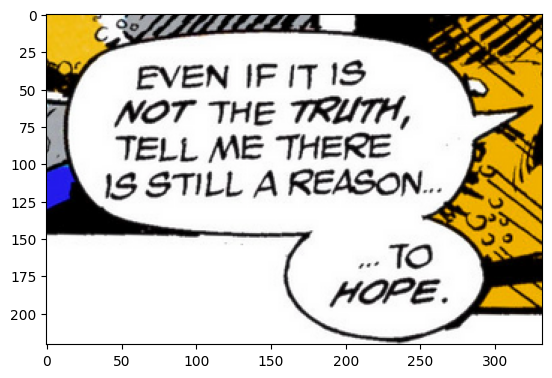

In [3]:
image_path = "bubble_11.png"
img=cv.imread(image_path)
plt.imshow(img)

In [4]:
def angle_between_vectors(v1,v2):
    dot_product = np.dot(v1,v2) 
    magnitude = np.linalg.norm(v1) * np.linalg.norm(v2)
    cos_angle = dot_product/magnitude
    angle = np.arccos(np.clip(cos_angle,-1,1))
    return np.degrees(angle)

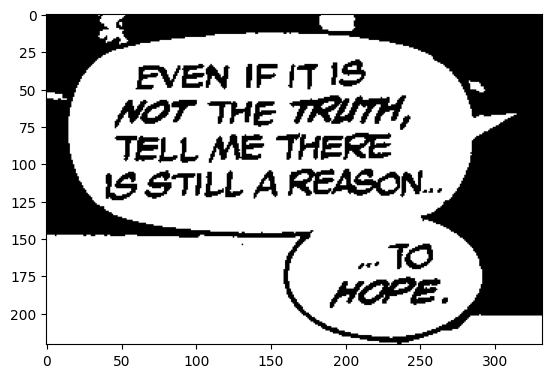

In [5]:
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
limit1 = (0, 0, 200)
limit2 = (180,20, 255)
mask = cv.inRange(hsv, limit1, limit2)
plt.imshow(mask, cmap='gray')

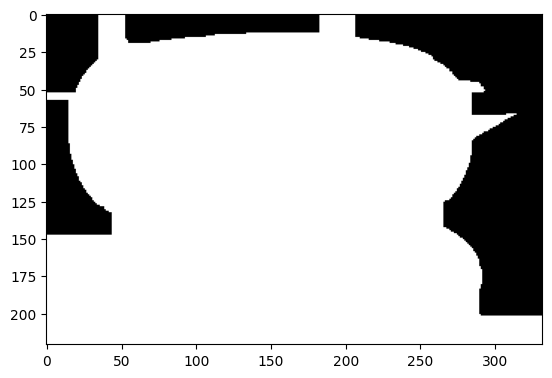

In [6]:
mask=cv.dilate(mask, None, iterations=7)
mask=cv.erode(mask, None, iterations=7)
plt.imshow(mask, cmap='gray')

# centro do contorno
# pegar ponto de maior distancia do centro
# tracar reta entre centro e ponto de maior distancia
# ou 
# pegar ponto de maior derivada negativa do contorno
# ou
# # detector de cantos Harris

150 121


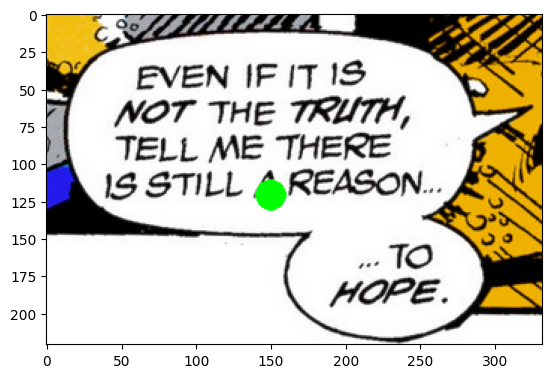

In [7]:
# pegar centro do maior contorno
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contour = max(contours, key=cv.contourArea)
M = cv.moments(contour)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print(cx, cy)
cv.circle(img, (cx, cy), 5, (0, 255, 0), 10)
plt.imshow(img, cmap='gray')

150 121 13 133


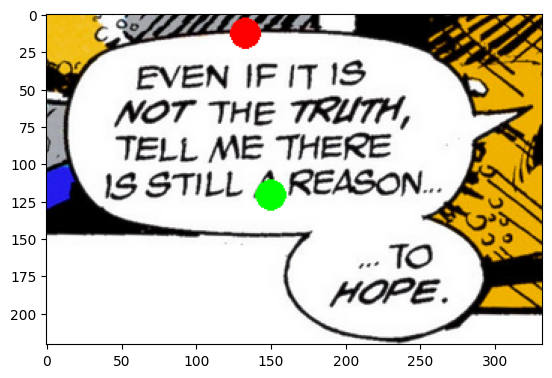

In [8]:
# pegar ponto de maior derivada negativa do contorno
img=cv.imread(image_path)
""" diff = np.diff(contour, axis=0)
max_diff = 0
max_diff_point = None
for i in range(len(diff)):
    x, y = diff[i][0]
    distance = np.sqrt(x**2 + y**2)
    if distance > max_diff and x > 0 and y > 0:
        max_diff = distance
        max_diff_point = contour[i][0] """

gradient_x = cv.Sobel(mask, cv.CV_64F, 1, 0, ksize=3)
gradient_y = cv.Sobel(mask, cv.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
max_gradient_value = np.max(gradient_magnitude)
max_diff_point = np.unravel_index(np.argmax(gradient_magnitude), gradient_magnitude.shape)

x, y = max_diff_point
print(cx, cy, x, y)
cv.circle(img, (cx, cy), 5, (0, 255, 0), 10)
cv.circle(img, (y, x), 5, (255, 0, 0), 10)
plt.imshow(img, cmap='gray')


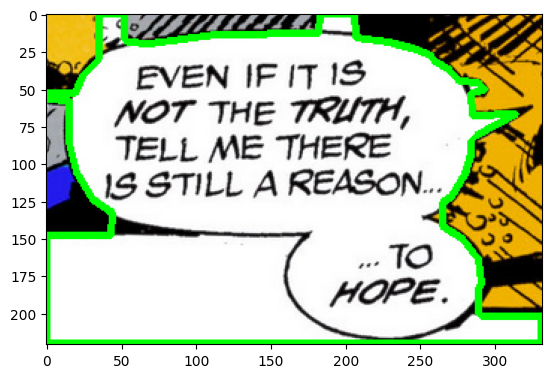

In [9]:
img = cv.imread(image_path)
epsilon = 0.001 * cv.arcLength(contour, True)
approx = cv.approxPolyDP(contour, epsilon, True)
cv.drawContours(img, [approx], -1, (0, 255, 0), 3)
target_point = (approx[:,0,0].min() + approx[:,0,0].max()) // 2, approx[:,0,1].max()  # Adjust for your specific point of interest
closest_point = min(approx, key=lambda point: np.linalg.norm(point[0] - target_point))
#cv.circle(img, tuple(closest_point[0]), 5, (255, 0, 0), 10)
plt.imshow(img, cmap='gray')

[314  67]
26.325821755124394


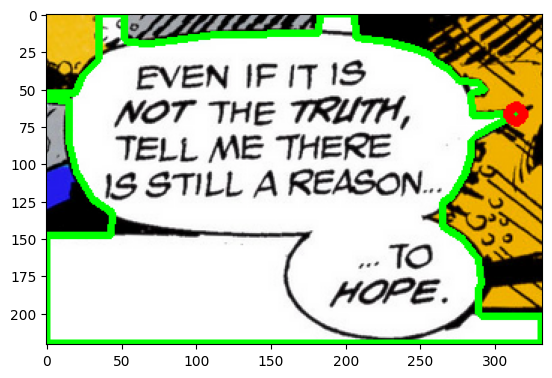

In [10]:
min_angle = float("inf")
num_points = len(approx)
for i in range(num_points):
    p1 = approx[i][0]
    p2 = approx[(i+1)%num_points][0]
    p3 = approx[(i+2)%num_points][0]
    #cv.circle(img,p2,5,(255,0,0),10)
    v1 = p1 - p2
    v2 = p3 - p2
    angle = angle_between_vectors(v1, v2)
    #print(angle)
    if angle < min_angle and angle > 0 and angle < 90:
        min_angle = angle
        min_angle_point = p2

print(min_angle_point)
print(min_angle)
cv.circle(img, tuple(min_angle_point), 5, (255, 0, 0), 5)
plt.imshow(img, cmap='gray')

In [11]:
def line_coefficients(point1, point2):
    # Convert points to numpy array of shape (N,1,2)
    points = np.array([point1, point2], dtype=np.float32).reshape(-1, 1, 2)
    
    # Fit a line to the points
    vx, vy, x, y = cv.fitLine(points, cv.DIST_L2, 0, 0.01, 0.01)
    
    # Calculate the slope (m) and y-intercept (b) of the line
    m = vy / vx
    b = y - m * x
    
    return m, b

[164 -54]


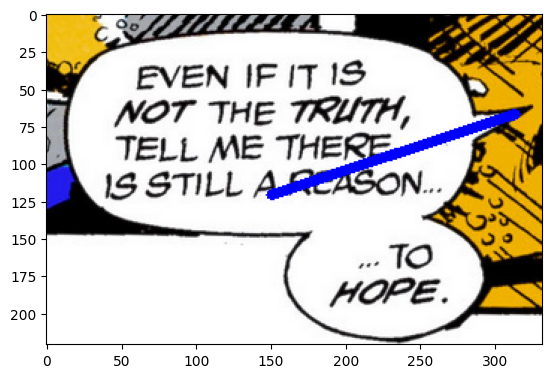

In [21]:
cv.line(img, (cx, cy), (min_angle_point[0], min_angle_point[1]), (0, 0, 255), 5)
direction = min_angle_point - (cx, cy)
print(direction)
plt.imshow(img, cmap='gray')

-39.6524658203125


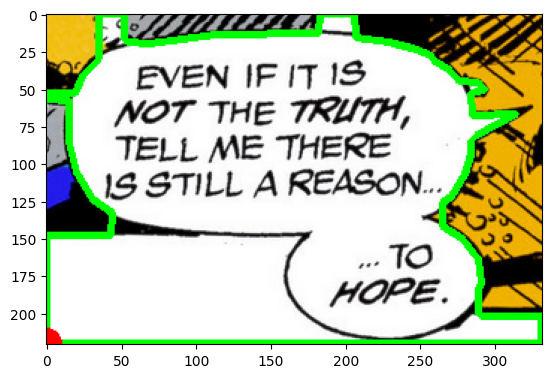

In [13]:
img = cv.imread(image_path)
epsilon = 0.001 * cv.arcLength(contour, True)
approx = cv.approxPolyDP(contour, epsilon, True)
ellipse = cv.fitEllipse(approx)
angle = ellipse[2]
if angle > 90:
    angle -= 180
rotated_image = np.copy(img)
rotated_contour = cv.rotate(approx, cv.ROTATE_90_COUNTERCLOCKWISE if angle > 0 else cv.ROTATE_90_CLOCKWISE)
cv.drawContours(rotated_image, [approx], -1, (0, 255, 0), 3)
hull = cv.convexHull(approx)
target_point = (hull[:,0,0].min() + hull[:,0,0].max()) // 2, hull[:,0,1].max()  # Adjust for your specific point of interest
closest_point = min(hull, key=lambda point: np.linalg.norm(point[0] - target_point))
cv.circle(rotated_image, tuple(closest_point[0]), 5, (255, 0, 0), 10)
plt.imshow(rotated_image, cmap='gray')
print(angle)

# TODO achar menor angulo convexo do poligono

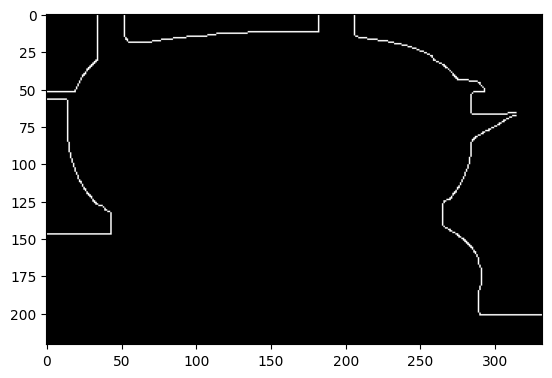

In [14]:
canny = cv.Canny(mask, 100, 200)
plt.imshow(canny, cmap='gray')